In [1]:
import pandas as pd


comp_data = 'compiled_upright_torque_july11.dat'

df = pd.read_csv(comp_data, sep=',')
df

,rod_id,trial,measurement_index,point_index,value
0,Rod3,N1,0,0,-0.00129
1,Rod3,N1,0,1,-0.02068
2,Rod3,N1,0,2,-0.02184
3,Rod3,N1,0,3,-0.02496
4,Rod3,N1,0,4,-0.02710
...,...,...,...,...,...
5695,Rod3,N12,99,3,-0.02216
5696,Rod3,N12,99,4,-0.02364
5697,Rod3,N12,99,5,-0.02364
5698,Rod3,N12,99,6,-0.02726


In [2]:
rod_chars = 'dataTorque/rod-lenght.txt'
dfC = pd.read_csv(rod_chars)
# Filter out broken rods (optional)
dfC = dfC[dfC['Rod'].str.contains("Rod") & ~dfC['Rod'].str.contains("not working|broken", case=False)].copy()

# Standardize rod_id
dfC['rod_id'] = dfC['Rod'].str.extract(r'(Rod\d+)')
# First merge main df with rod characteristics
df_merged = pd.merge(df, dfC.drop(columns=['Rod']), on='rod_id', how='left')
df_merged


,rod_id,trial,measurement_index,point_index,value,material,lenght,diammeter
0,Rod3,N1,0,0,-0.00129,al,182mm,1.6mm
1,Rod3,N1,0,1,-0.02068,al,182mm,1.6mm
2,Rod3,N1,0,2,-0.02184,al,182mm,1.6mm
3,Rod3,N1,0,3,-0.02496,al,182mm,1.6mm
4,Rod3,N1,0,4,-0.02710,al,182mm,1.6mm
...,...,...,...,...,...,...,...,...
5695,Rod3,N12,99,3,-0.02216,al,182mm,1.6mm
5696,Rod3,N12,99,4,-0.02364,al,182mm,1.6mm
5697,Rod3,N12,99,5,-0.02364,al,182mm,1.6mm
5698,Rod3,N12,99,6,-0.02726,al,182mm,1.6mm


In [3]:
# Length of the rod (inches)
rod_length_in = 3.84375

# Heights measured *from tip of rod to ruler bottom* (inches)
height_in_dict = {
    "N1": 0.94,  "N12": 0.94,   # Height‑setting 1, runs A/B
    "N2": 1.90, "N22": 1.90,    # Height‑setting 2, runs A/B
    "N3": 2.86, "N32": 2.86,    # Height‑setting 3, runs A/B
    "N4": 3.82, "N42": 3.82,    # Height‑setting 4, runs A/B
}

# Convert “tip‑to‑bottom” measurements into the height of the **top of the rod**
# relative to the ruler’s bottom (i.e., remaining rod length above the ruler)
clearance_in_dict = {label: rod_length_in - h for label, h in height_in_dict.items()}

# Convert to millimetres (1 inch = 25.4 mm)
height_mm_dict = {k: v * 25.4 for k, v in clearance_in_dict.items()}

# Turn into a DataFrame so we can merge
height_df = (
    pd.Series(height_mm_dict, name='height_mm')
      .rename_axis('trial')
      .reset_index()
)

df_merged = (
    df_merged  # <- your original dataframe variable
    .merge(height_df, on='trial', how='left')
)
df_merged

,rod_id,trial,measurement_index,point_index,value,material,lenght,diammeter,height_mm
0,Rod3,N1,0,0,-0.00129,al,182mm,1.6mm,73.75525
1,Rod3,N1,0,1,-0.02068,al,182mm,1.6mm,73.75525
2,Rod3,N1,0,2,-0.02184,al,182mm,1.6mm,73.75525
3,Rod3,N1,0,3,-0.02496,al,182mm,1.6mm,73.75525
4,Rod3,N1,0,4,-0.02710,al,182mm,1.6mm,73.75525
...,...,...,...,...,...,...,...,...,...
5695,Rod3,N12,99,3,-0.02216,al,182mm,1.6mm,73.75525
5696,Rod3,N12,99,4,-0.02364,al,182mm,1.6mm,73.75525
5697,Rod3,N12,99,5,-0.02364,al,182mm,1.6mm,73.75525
5698,Rod3,N12,99,6,-0.02726,al,182mm,1.6mm,73.75525


In [4]:
position_map = { #mm
    0: 0,
    1: 100,
    2: 90,
    3: 80,
    4: 70,
    5: 60,
    6: 50,
    7: 40,
    # Add more if needed
}

summary_df = (
    df_merged
    .groupby(['rod_id','trial', 'point_index'])
    .agg(
       mean_voltage=('value', 'mean'),
       std_voltage=('value', 'std')
    )
    .reset_index()
)
summary_df['position'] = summary_df['point_index'].map(position_map)
  # X axis

# Merge height_mm from df_merged
height_lookup = df_merged[['trial', 'height_mm']].drop_duplicates()
summary_df = summary_df.merge(height_lookup, on='trial', how='left')

# Optionally reorder columns
summary_df = summary_df[['rod_id','trial', 'point_index', 'position', 'height_mm','mean_voltage', 'std_voltage']]

summary_df

,rod_id,trial,point_index,position,height_mm,mean_voltage,std_voltage
0,Rod3,N1,0,0,73.75525,-0.001195,0.000138
1,Rod3,N1,1,100,73.75525,-0.020363,0.000127
2,Rod3,N1,2,90,73.75525,-0.021893,0.000121
3,Rod3,N1,3,80,73.75525,-0.024997,0.000147
4,Rod3,N1,4,70,73.75525,-0.027393,0.000128
5,Rod3,N1,5,60,73.75525,-0.028607,0.000147
6,Rod3,N1,6,50,73.75525,-0.034607,0.000122
7,Rod3,N12,0,0,73.75525,0.000316,0.000139
8,Rod3,N12,1,100,73.75525,-0.018481,0.000133
9,Rod3,N12,2,90,73.75525,-0.019840,0.000157


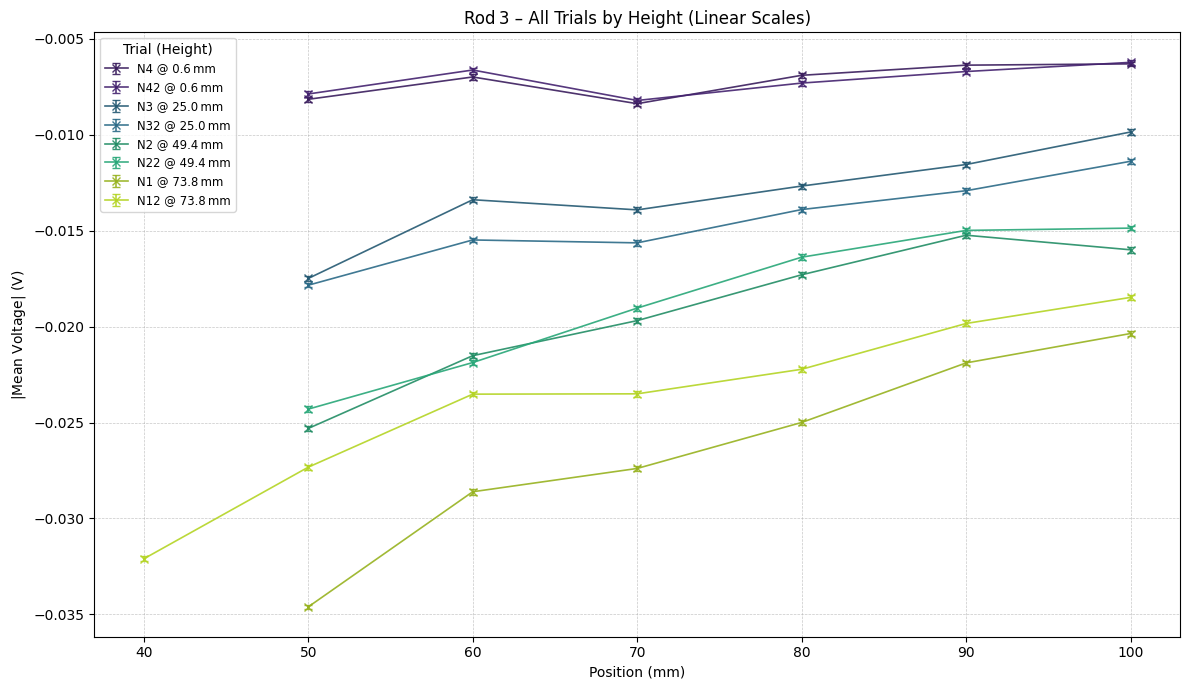

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_voltage_vs_position(summary_df):
    """
    Plot |mean_voltage| (with error bars) versus position for every trial,
    grouped and colour‑coded by height. Linear scales are used on both axes.
    """

    # Filter out the origin point and any rows without a positive position
    df = summary_df[
        (summary_df['point_index'] != 0) &      # skip point_index 0 if desired
        (summary_df['position'] > 0)
    ].copy()

    # Build a base colour per height, then vary the brightness for each trial
    heights = sorted(df['height_mm'].unique())
    base_colors = cm.viridis(np.linspace(0.1, 0.9, len(heights)))
    height_color_map = dict(zip(heights, base_colors))

    plt.figure(figsize=(12, 7))

    for height in heights:
        df_h = df[df['height_mm'] == height]
        base_color = np.array(height_color_map[height])
        trials = sorted(df_h['trial'].unique())

        for i, trial in enumerate(trials):
            d = df_h[df_h['trial'] == trial]

            # Alternate brightness to distinguish trials at the same height
            brightness = 0.8 + 0.15 * (i % 2)
            color = tuple(np.clip(base_color * brightness, 0, 1))

            plt.errorbar(
                d['position'],
                d['mean_voltage'],
                yerr=d['std_voltage'],
                label=f'{trial} @ {height:.1f} mm',
                marker='x',
                markersize=6,
                linestyle='-',
                linewidth=1.2,
                capsize=3,
                color=color,
                alpha=0.9
            )

    plt.xlabel('Position (mm)')
    plt.ylabel(r'$|\mathrm{Mean\ Voltage}|$ (V)')
    plt.title('Rod 3 – All Trials by Height (Linear Scales)')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title='Trial (Height)', fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()

plot_voltage_vs_position(summary_df)


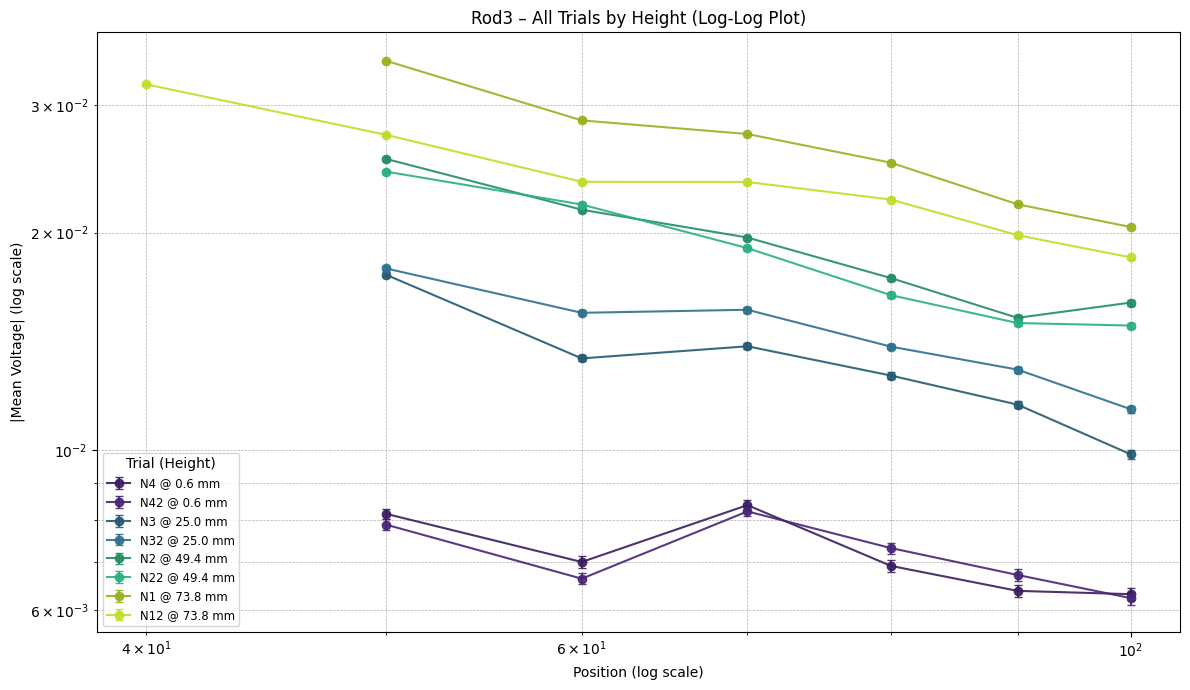


=== Standard Deviation of Voltage by Height and Trial ===

position             40       50       60       70       80       90       100
height_mm trial                                                               
73.75525  N12    0.00012  0.00013  0.00012  0.00015  0.00013  0.00016  0.00013
          N1         NaN  0.00012  0.00015  0.00013  0.00015  0.00012  0.00013
49.37125  N22        NaN  0.00015  0.00015  0.00013  0.00015  0.00013  0.00011
          N2         NaN  0.00014  0.00014  0.00013  0.00014  0.00013  0.00015
24.98725  N32        NaN  0.00011  0.00012  0.00014  0.00012  0.00012  0.00013
          N3         NaN  0.00014  0.00013  0.00013  0.00013  0.00012  0.00014
0.60325   N42        NaN  0.00014  0.00012  0.00013  0.00013  0.00012  0.00013
          N4         NaN  0.00013  0.00013  0.00013  0.00013  0.00013  0.00012


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_all_heights_loglog(summary_df):
    df = summary_df[
        (summary_df['point_index'] != 0) &
        (summary_df['position'] > 0)
    ].copy()

    df['abs_voltage'] = df['mean_voltage'].abs()
    df['std_voltage'] = df['std_voltage'].replace(0, np.nan)

    heights = sorted(df['height_mm'].unique())
    base_colors = cm.viridis(np.linspace(0.1, 0.9, len(heights)))
    height_color_map = dict(zip(heights, base_colors))

    plt.figure(figsize=(12, 7))

    for height in heights:
        df_h = df[df['height_mm'] == height]
        base_color = np.array(height_color_map[height])
        trials = sorted(df_h['trial'].unique())

        for i, trial in enumerate(trials):
            d = df_h[df_h['trial'] == trial]

            # Slight brightness variation per trial
            brightness = 0.8 + 0.2 * (i % 2)  # alternate between normal and slightly brighter
            color = tuple(np.clip(base_color * brightness, 0, 1))

            plt.errorbar(
                d['position'],
                d['abs_voltage'],
                yerr=d['std_voltage'],
                label=f'{trial} @ {height:.1f} mm',
                marker='o',
                linestyle='-',
                capsize=3,
                color=color,
                alpha=0.9
            )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Position (log scale)')
    plt.ylabel('|Mean Voltage| (log scale)')
    plt.title('Rod3 – All Trials by Height (Log-Log Plot)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(title='Trial (Height)', fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()

        # Now print the std_voltage table
    print("\n=== Standard Deviation of Voltage by Height and Trial ===\n")

    grouped = (
        df.groupby(['height_mm', 'trial', 'position'])['std_voltage']
        .first()
        .unstack('position')
        .sort_index(level=0, ascending=False)
        .round(5)
    )

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(grouped)

plot_all_heights_loglog(summary_df)


In [7]:
import numpy as np
from scipy.optimize import curve_fit

# ----------  MODEL ----------
def linear_model(x: np.ndarray, m: float, b: float) -> np.ndarray:
    """y = m x + b"""
    return m * x + b


# ----------  ERROR PROPAGATION ----------
def compute_sigma_eff(x: np.ndarray,
                      sigma_x: np.ndarray,
                      sigma_y: np.ndarray,
                      model_func,
                      params,
                      rel_step: float = 1e-6) -> np.ndarray:
    """
    Returns 1‑σ effective uncertainties √[σ_y² + (df/dx·σ_x)²].

    rel_step scales the finite‑difference step to |x| to stay in a safe range.
    """
    x = np.asarray(x, dtype=float)
    sigma_x = np.asarray(sigma_x, dtype=float)
    sigma_y = np.asarray(sigma_y, dtype=float)

    # Finite‑difference derivative df/dx
    delta = rel_step * np.maximum(1.0, np.abs(x))
    df_dx = (model_func(x + delta, *params) - model_func(x - delta, *params)) / (2.0 * delta)

    sigma_eff2 = sigma_y**2 + (df_dx * sigma_x)**2
    return np.sqrt(sigma_eff2)


# ----------  CURVE FIT ----------
def perform_curve_fit(x, y, sigma_x, sigma_y,
                      model_func=linear_model,
                      initial_guess=(0.0, 0.0),
                      tol=1e-10,
                      max_iter=6):
    """
    Iteratively refits until parameters change < tol or max_iter reached.
    Returns (popt, pcov, sigma_eff) with σ_x properly propagated.
    """
    # First pass (ignore σ_x)
    popt, pcov = curve_fit(model_func, x, y,
                           sigma=sigma_y, absolute_sigma=True, p0=initial_guess)

    for _ in range(max_iter):
        sigma_eff = compute_sigma_eff(x, sigma_x, sigma_y, model_func, popt)
        popt_new, pcov_new = curve_fit(model_func, x, y,
                                       sigma=sigma_eff, absolute_sigma=True, p0=popt)
        if np.allclose(popt, popt_new, rtol=0, atol=tol):
            break
        popt, pcov = popt_new, pcov_new

    return popt, pcov, sigma_eff


# ----------  CHI‑SQUARED ----------
def compute_chi_squared(x, y, sigma_eff, model_func, params):
    """
    χ² and reduced χ² using already‑computed σ_eff.
    """
    resid = y - model_func(x, *params)
    chi2 = np.sum((resid / sigma_eff) ** 2)
    dof = len(y) - len(params)
    return chi2, chi2 / dof


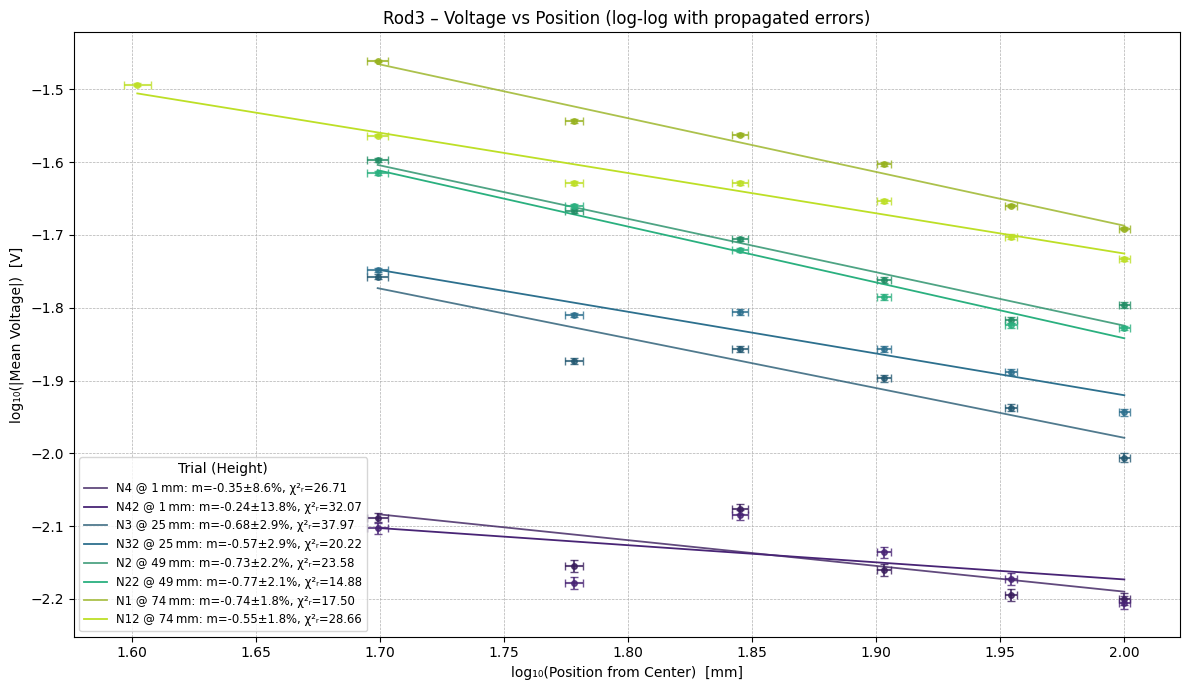

In [10]:
# --- YOUR UPDATED UTILITIES MUST BE IMPORTED OR DEFINED ABOVE THIS POINT ---
# from fit_utils import linear_model, perform_curve_fit, compute_chi_squared

def plot_loglog_all_heights_with_fit(summary_df):
    """Plot |mean_voltage| vs position (log–log) for each height & trial, with total‑error fits."""
    # ---------- 1.  DATA PREP ----------
    df = summary_df[
        (summary_df['position'] > 0) &          # ignore center point (log undefined)
        (summary_df['mean_voltage'] != 0) &
        (summary_df['point_index'] != 0)
    ].copy()

    df['abs_voltage'] = df['mean_voltage'].abs()
    df['std_voltage'] = df['std_voltage'].replace(0, np.nan)
    df['sigma_x'] = 0.5    # mm height uncertainty (edit as needed)

    heights = np.sort(df['height_mm'].unique())
    base_colors = cm.viridis(np.linspace(0.1, 0.9, len(heights)))
    height_color_map = dict(zip(heights, base_colors))

    fig, ax = plt.subplots(figsize=(12, 7))

    # ---------- 2.  LOOP THROUGH HEIGHTS & TRIALS ----------
    for height in heights:
        df_h = df[df['height_mm'] == height]
        base_color = height_color_map[height]
        trials = np.sort(df_h['trial'].unique())

        for i, trial in enumerate(trials):
            group = df_h[df_h['trial'] == trial]

            # Raw values
            x_raw  = group['position'    ].to_numpy()
            y_raw  = group['abs_voltage' ].to_numpy()
            sx_raw = group['sigma_x'     ].to_numpy()
            sy_raw = group['std_voltage' ].to_numpy()

            # Convert to log10 space
            log_x = np.log10(x_raw)
            log_y = np.log10(y_raw)

            # Error propagation
            sigma_log_x = sx_raw / (x_raw * np.log(10))
            sigma_log_y = sy_raw / (y_raw * np.log(10))

            # ---------- 3.  FIT ----------
            popt, pcov, sigma_eff = perform_curve_fit(
                log_x, log_y, sigma_log_x, sigma_log_y,
                model_func=linear_model,
                initial_guess=(-1.0, 0.0)
            )
            slope, intercept = popt
            chi2, chi2_red   = compute_chi_squared(log_x, log_y, sigma_eff, linear_model, popt)

            m_err = np.sqrt(pcov[0, 0])
            percent_err = abs(m_err / slope) * 100 if slope != 0 else np.nan

            # ---------- 4.  STYLING ----------
            brightness = 0.8 + 0.2 * (i % 2)          # alternate brightness
            color = tuple(np.clip(base_color * brightness, 0, 1))

            # Data points
            ax.errorbar(
                log_x, log_y, xerr=sigma_log_x, yerr=sigma_log_y,
                fmt='o', capsize=3, markersize=4, alpha=0.8, color=color
            )

            # Fit line
            x_fit = np.linspace(log_x.min(), log_x.max(), 200)
            y_fit = linear_model(x_fit, *popt)
            ax.plot(
                x_fit, y_fit, color=color, linewidth=1.3,
                label=f'{trial} @ {height:.0f} mm: m={slope:.2f}±{percent_err:.1f}%, χ²ᵣ={chi2_red:.2f}'
            )

    # ---------- 5.  FINISHING TOUCHES ----------
    ax.set_title("Rod3 – Voltage vs Position (log‑log with propagated errors)")
    ax.set_xlabel("log₁₀(Position from Center)  [mm]")
    ax.set_ylabel("log₁₀(|Mean Voltage|)  [V]")
    ax.grid(True, which='both', ls='--', lw=0.5)
    ax.legend(title='Trial (Height)', fontsize='small', loc='best')
    plt.tight_layout()
    plt.savefig('/Users/danieljuarezluna/Library/CloudStorage/OneDrive-CreightonUniversity/MSc Physics/001-MRI Safety Thesis/plots/al_upright_LogLog_fit_allHeights.png', dpi=300)
    plt.show()
#'/Users/danieljuarezluna/Library/CloudStorage/OneDrive-CreightonUniversity/MSc Physics/001-MRI Safety Thesis/plots'

plot_loglog_all_heights_with_fit(summary_df)


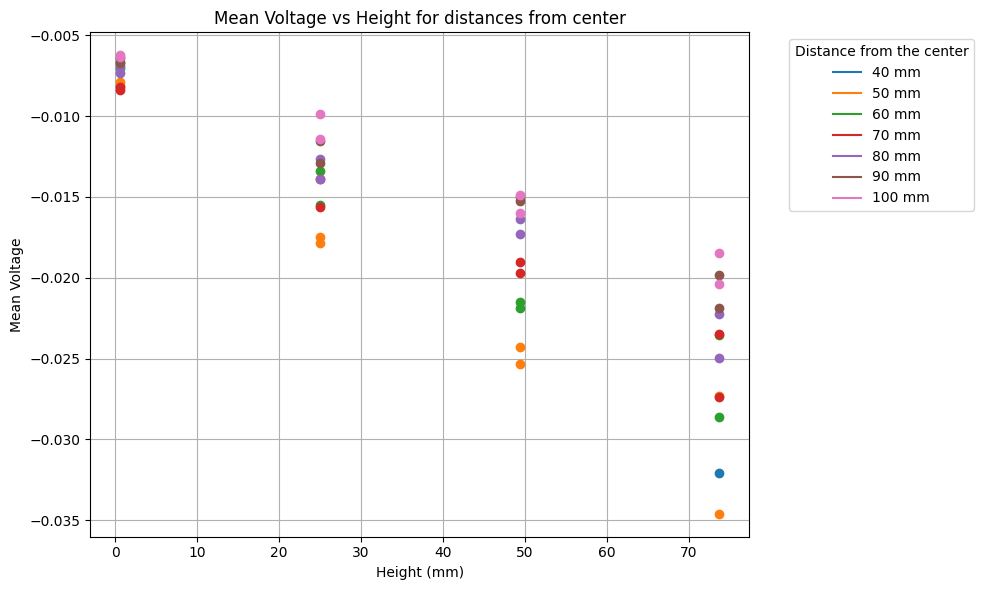

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Filter data
df = summary_df[
    (summary_df['position'] > 0) &
    (summary_df['mean_voltage'] != 0) &
    (summary_df['point_index'] != 0)
].copy()

positions = sorted(df['position'].unique())

# Base colors for each position
cmap = plt.get_cmap('tab10')
base_colors = {pos: np.array(cmap(i % 10)[:3]) for i, pos in enumerate(positions)}

plt.figure(figsize=(10,6))

# Assign unique marker per trial
marker_styles = ['.']#'x', '+', '_', '|', '3', '4','1', '2']
trials_all = sorted(df['trial'].unique())
trial_markers = {trial: marker_styles[i % len(marker_styles)] for i, trial in enumerate(trials_all)}


for pos in positions:
    df_pos = df[df['position'] == pos]
    trials_pos = sorted(df_pos['trial'].unique())
    
    df_pos_sorted = df_pos.sort_values('height_mm')
    grouped = df_pos_sorted.groupby(['trial', 'height_mm'])['mean_voltage'].mean().reset_index()

    base_color = base_colors[pos]

    for trial in trials_pos:
        df_trial = grouped[grouped['trial'] == trial]
        if df_trial.empty:
            continue
        marker = trial_markers[trial]
        plt.plot(df_trial['height_mm'], df_trial['mean_voltage'], 
                 marker=marker, linestyle='-', color=base_color,
                 markersize=12,
                 label=f'Position {pos} Trial {trial}')


# To avoid legend clutter, show only positions
import matplotlib.lines as mlines
legend_handles = []
for pos in positions:
    legend_handles.append(mlines.Line2D([], [], color=base_colors[pos], label=f'{pos} mm'))
plt.legend(handles=legend_handles, title='Distance from the center', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Height (mm)')
plt.ylabel('Mean Voltage')
plt.title('Mean Voltage vs Height for distances from center')
plt.grid(True)
plt.tight_layout()

plt.savefig('/Users/danieljuarezluna/Library/CloudStorage/OneDrive-CreightonUniversity/MSc Physics/001-MRI Safety Thesis/plots/mean_voltage_vs_height_by_position_and_trial.png', dpi=300, bbox_inches='tight')

plt.show()


  trial  height_mm  mean_voltage
0    N1   73.75525     -0.034607
1    N2   49.37125     -0.025309
2    N3   24.98725     -0.017494
3    N4    0.60325     -0.008161
  trial  height_mm  mean_voltage
0    N1   73.75525     -0.028607
1    N2   49.37125     -0.021518
2    N3   24.98725     -0.013393
3    N4    0.60325     -0.006998
  trial  height_mm  mean_voltage
0    N1   73.75525     -0.027393
1    N2   49.37125     -0.019691
2    N3   24.98725     -0.013921
3    N4    0.60325     -0.008389
  trial  height_mm  mean_voltage
0    N1   73.75525     -0.024997
1    N2   49.37125     -0.017303
2    N3   24.98725     -0.012680
3    N4    0.60325     -0.006911
  trial  height_mm  mean_voltage
0    N1   73.75525     -0.021893
1    N2   49.37125     -0.015242
2    N3   24.98725     -0.011558
3    N4    0.60325     -0.006382
  trial  height_mm  mean_voltage
0    N1   73.75525     -0.020363
1    N2   49.37125     -0.016002
2    N3   24.98725     -0.009864
3    N4    0.60325     -0.006315


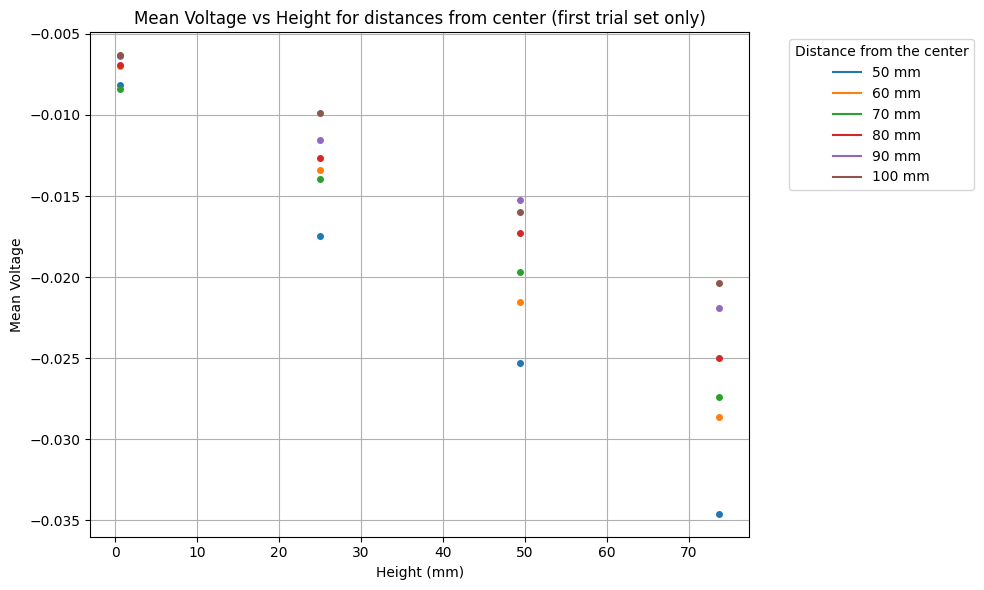

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Filter data
df = summary_df[
    (summary_df['position'] > 0) &
    (summary_df['mean_voltage'] != 0) &
    (summary_df['point_index'] != 0)
].copy()

# Keep only N1, N2, N3, N4... (ignore N12, N22, etc.)
df = df[df['trial'].str.match(r'^N\d$')]

positions = sorted(df['position'].unique())

# Base colors for each position
cmap = plt.get_cmap('tab10')
base_colors = {pos: np.array(cmap(i % 10)[:3]) for i, pos in enumerate(positions)}

plt.figure(figsize=(10,6))

# Assign unique marker per trial
marker_styles = ['.']#,'x','+','^','v','s','D','*']  # optional variety
trials_all = sorted(df['trial'].unique())
trial_markers = {trial: marker_styles[i % len(marker_styles)] for i, trial in enumerate(trials_all)}

for pos in positions:
    df_pos = df[df['position'] == pos]
    trials_pos = sorted(df_pos['trial'].unique())
    
    df_pos_sorted = df_pos.sort_values('height_mm')
    grouped = df_pos_sorted.groupby(['trial', 'height_mm'])['mean_voltage'].mean().reset_index()

    base_color = base_colors[pos]
    print(grouped.head(20))
    for trial in trials_pos:
        df_trial = grouped[grouped['trial'] == trial]
        if df_trial.empty:
            continue
        marker = trial_markers[trial]
        plt.plot(
            df_trial['height_mm'], df_trial['mean_voltage'], 
            marker=marker, linestyle='-.', color=base_color,
            markersize=8,
            label=f'Position {pos} {trial}'
        )

# Legend: show only positions (not cluttered with trial labels)
legend_handles = []
for pos in positions:
    legend_handles.append(mlines.Line2D([], [], color=base_colors[pos], label=f'{pos} mm'))
plt.legend(handles=legend_handles, title='Distance from the center', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Height (mm)')
plt.ylabel('Mean Voltage')
plt.title('Mean Voltage vs Height for distances from center (first trial set only)')
plt.grid(True)
plt.tight_layout()

plt.savefig('/Users/danieljuarezluna/Library/CloudStorage/OneDrive-CreightonUniversity/MSc Physics/001-MRI Safety Thesis/plots/mean_voltage_vs_height_by_position_first_trials.png', dpi=300, bbox_inches='tight')
plt.show()
